# Optiver Trading At The Close

[Competition](https://www.kaggle.com/competitions/optiver-trading-at-the-close)

[GitHub Repository](https://github.com/cvaisnor/DNN-Final-Project)

[Google Slides Presentation](https://docs.google.com/presentation/d/1Xc5F1_NveFi1il3GqHej2aqVmklR_jZU4kx6ZJhiDEM/edit?usp=sharing)

# General Imports

In [66]:
import os
import numpy as np
import pandas as pd
import importlib

import helpers

kaggle_environment = False # True if running on Kaggle, don't forget to add the dataset!

from helpers.common import load_data, plot_predictions, submit_dummy_predictions
from helpers.pipeline import LogFeatures, LagFeatures, RollingMeanFeatures, DiffFeatures, ExpandingMeanFeatures, \
ForwardFillValues, FillZero, DataFrameWrapper, PolynomialFeaturesWrapper, MissingValueImputer, DropColumns, FillOne

if not kaggle_environment:
    # Reload the modules
    importlib.reload(helpers.common)
    importlib.reload(helpers.pipeline)

# Loading Data

In [97]:
original_train, test, revealed_targets, sample_submission = load_data(kaggle_environment)

In [98]:
split_ratio = 0.8  # 80% for training, 20% for testing
split_idx = int(len(original_train) * split_ratio)

train = original_train.iloc[:split_idx]
test = original_train.iloc[split_idx:]

train = train.dropna(subset=['target'])
test = test.dropna(subset=['target'])

# train = train.dropna()
# test = test.dropna()

# Subsample training
num_samples = 2000000
if train.shape[0] > num_samples:
    train = train[-num_samples:]

y = train['target'].values
y_test = test['target'].values

In [99]:
print(train.shape)
print(test.shape)

(2000000, 17)
(1047540, 17)


In [100]:
test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
4190384,4,385,420,9375764.34,1,1.001523,39592192.74,1.002241,1.002020,1.001413,5801.28,1.001634,181.33,1.001627,10.470152,21217,385_420_4
4190385,5,385,420,297718.61,1,1.006371,6720703.44,1.017943,1.007021,1.006111,26154.44,1.006371,79412.40,1.006175,-16.819836,21217,385_420_5
4190386,6,385,420,740319.79,-1,0.999097,13409310.36,0.980418,0.998220,0.998964,223708.10,0.999628,8653.29,0.999603,-2.580285,21217,385_420_6
4190387,7,385,420,0.00,0,1.001721,80638467.42,1.001721,1.001721,1.001296,22252.93,1.001799,4142.16,1.001720,-4.959702,21217,385_420_7
4190388,8,385,420,1607504.50,-1,1.000868,54598272.07,0.989186,1.000294,1.000755,269769.55,1.001571,143664.26,1.001288,-2.650022,21217,385_420_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


# Feature Engineering Section

In [101]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Column Preprocessor
columns_to_keep = [
    'imbalance_size_log', 'matched_size_log', #'stock_id',
    'imbalance_buy_sell_flag', 'reference_price',
    'far_price', 'near_price', 'bid_price', 'bid_size_log', 'ask_price', 'ask_size_log', 'wap_log', 'wap_log_lag_1',
    #'wap_log_lag_5', # 'wap_lag10', 'wap_lag15', 'wap_lag20',
    'wap_log_rolling_mean2', #'wap_log_rolling_mean3', #'wap_log_rolling_mean5',
    'wap_log_diff', 'wap_log_expanding_mean', 'seconds_in_bucket',
    'matched_size_lag_1', 'matched_size_lag_3'
]

one_hot_cols = []
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), one_hot_cols),
        ('passthrough', 'passthrough', columns_to_keep)
    ],
    remainder='drop'  # Drop other columns
)

drop_columns=['target', 'bid_size', 'ask_size', 'imbalance_size', 'matched_size', 'time_id', 'row_id', 'currently_scored']

# Main Pipeline
pipeline = Pipeline([
    ('logs', LogFeatures(['imbalance_size', 'matched_size', 'bid_size', 'ask_size'])),
    ('wap_lags', LagFeatures(['wap'], [1, 6], 1.0)),
    ('matched_size_lags', LagFeatures(['matched_size'], [1, 6], 0.0)),
    ('wap_rolling_means', RollingMeanFeatures(['wap'], [2])),
    ('diff_features', DiffFeatures(['wap', 'imbalance_buy_sell_flag', 'matched_size_log', 'ask_price', 'reference_price'])),
    ('diff_features_2', DiffFeatures(['wap_diff', 'matched_size_log_diff', 'ask_price_diff', 'reference_price_diff'])),
    ('diff_features_3', DiffFeatures(['wap_diff_diff', 'matched_size_log_diff_diff', 'ask_price_diff_diff', 'reference_price_diff_diff'])),
    ('wap_expanding_mean', ExpandingMeanFeatures(['wap'])),
    ('drop_columns', DropColumns(drop_columns)),
#     ('missing_value_imputer', MissingValueImputer(['far_price', 'near_price'])),
    ('forward_fill', ForwardFillValues()),
    # ('fill_zero', FillZero()),
    ('fill_one', FillOne()),
    # ('preprocessor', DataFrameWrapper(preprocessor, columns_to_keep)),
    ('drop_grouping_columns', DropColumns(['stock_id', 'date_id'])),
    # ('drop_grouping_columns', DropColumns(['date_id'])),
    ('scaler', DataFrameWrapper(StandardScaler())),
    # ('poly', PolynomialFeaturesWrapper(2)),
])

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
    train_transformed = pipeline.fit_transform(train)
    test_transformed = pipeline.transform(test)

CPU times: user 10.8 s, sys: 1.76 s, total: 12.6 s
Wall time: 12.6 s


In [102]:
X = train_transformed
X_test = test_transformed

In [103]:
X

,seconds_in_bucket,imbalance_buy_sell_flag,reference_price,far_price,near_price,bid_price,ask_price,wap,imbalance_size_log,matched_size_log,...,reference_price_diff,wap_diff_diff,matched_size_log_diff_diff,ask_price_diff_diff,reference_price_diff_diff,wap_diff_diff_diff,matched_size_log_diff_diff_diff,ask_price_diff_diff_diff,reference_price_diff_diff_diff,wap_expanding_mean
0,-0.063680,1.097241,1.120119,-0.001454,0.014150,0.791851,1.252886,0.996151,0.643626,0.072743,...,0.002213,-0.000116,-0.000393,-0.000072,-0.000110,-0.000160,-0.000101,-0.000126,-0.000161,1.578779
1,-0.063680,-0.026834,0.085595,-0.001454,0.014150,0.069230,0.033598,-0.032687,-1.885631,-0.270294,...,0.002213,-0.000116,-0.000393,-0.000072,-0.000110,-0.000160,-0.000101,-0.000126,-0.000161,-0.061306
2,-0.063680,1.097241,-0.528217,-0.001454,0.014150,-0.759379,-0.634135,-0.712674,0.263756,-1.059623,...,0.002213,-0.000116,-0.000393,-0.000072,-0.000110,-0.000160,-0.000101,-0.000126,-0.000161,-1.145281
3,-0.063680,1.097241,-0.520462,-0.001454,0.014150,-0.738891,-0.379090,-0.348072,1.002475,-0.003713,...,0.002213,-0.000116,-0.000393,-0.000072,-0.000110,-0.000160,-0.000101,-0.000126,-0.000161,-0.564064
4,-0.063680,-1.150909,-0.151321,-0.001454,0.014150,-0.242040,-0.006692,-0.203964,0.511138,-0.994850,...,0.002213,-0.000116,-0.000393,-0.000072,-0.000110,-0.000160,-0.000101,-0.000126,-0.000161,-0.334340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,0.881771,-1.150909,-0.592196,-2.092201,-4.020033,-0.496573,-0.578197,-0.574078,0.613482,0.366831,...,-0.656140,-0.611389,-0.038736,-0.472112,-0.468348,-0.732566,-0.030468,-0.547933,-0.542614,-0.068345
1999996,0.944801,1.097241,0.275982,1.775502,1.628455,0.309972,0.214712,0.286241,0.629686,0.706160,...,-0.408189,0.418047,-0.062873,0.441216,0.290258,0.520234,-0.066296,0.511994,0.506127,0.098077
1999997,0.944801,1.097241,1.402015,1.145878,1.096166,1.298552,1.336206,1.396977,0.342131,-0.343030,...,0.628503,1.740778,-0.012808,0.181364,1.425886,0.571352,-0.023772,-0.313286,0.568752,1.699582
1999998,0.944801,1.097241,0.728876,6.147086,2.733528,0.683497,0.734972,0.774082,0.505084,-0.349385,...,-0.329101,-0.485069,0.094882,-0.158444,0.235529,-0.594297,0.073641,-0.459606,0.091570,0.213844


In [104]:
# X['wap_lag_1']
# X[seconds_in_bucket]

All feature transformations should be combined into a generate_feature() function. This can then be applied to the test data will in the for loop for the Optiver API.

In [105]:
def generate_features(cumulative_test_df, current_test, pipeline):
    transformed_df = pipeline.transform(cumulative_test_df)
    
    # Only return rows corresponding to the current test dataframe
    return transformed_df.iloc[-len(current_test):]


# Slicing

Generally, don't change the cell below. It is used to slice the data into training and validation sets.

In [106]:
# imports
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y 

# Model Development

In [107]:
%%time
import lightgbm as lgb


# lgbm = lgb.LGBMRegressor(n_jobs=-1, random_state=0, force_col_wise=True,
#                          verbose=-1, boosting_type='gbdt', num_leaves=10,
#                          reg_alpha=0, reg_lambda=0.2, objective='regression_l1')

# lgbm = lgb.LGBMRegressor(n_jobs=-1, random_state=0, objective='regression_l1', num_leaves=100)
lgbm = lgb.LGBMRegressor(n_jobs=-1, reg_lambda=0.2, random_state=0, num_leaves=650, boosting_type='gbdt', reg_alpha=0.2, objective='regression_l1')
lgbm.fit(X_train, y_train)
# lgbm.fit(X_train.drop(columns=['row_id', 'time_id', 'target']), y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7206
[LightGBM] [Info] Number of data points in the train set: 2000000, number of used features: 31
[LightGBM] [Info] Start training from score -0.050068
CPU times: user 41.2 s, sys: 24.1 s, total: 1min 5s
Wall time: 34.8 s


LGBMRegressor(n_jobs=-1, num_leaves=650, objective='regression_l1',
              random_state=0, reg_alpha=0.2, reg_lambda=0.2)

In [108]:
# # Check for NaNs in y_test
# nan_in_y_test = np.isnan(y_test).any()
# print(f"NaN in y_test: {nan_in_y_test}")

# # Check for NaNs in predictions
# nan_in_predictions = np.isnan(predictions).any()
# print(f"NaN in predictions: {nan_in_predictions}")

In [109]:
# # Create a Tensorflow RNN separate for each stock
# import pandas as pd
# broken = pd.read_csv('/Users/cdurbin/Downloads/marko-broken-submission.csv')

In [110]:
# import numpy as np
# nan_info = np.isnan(broken['target']).any()
# print(f"NaN in broken: {nan_info}")
# print(broken.dtypes)

In [111]:
# working = pd.read_csv('/Users/cdurbin/Downloads/working-submission.csv')
# print(working.dtypes)

In [112]:
# print(working.describe())
# print(broken.describe())

In [113]:
# row_id_working = working['row_id']
# row_id_broken = broken['row_id']
# row_num = 32999
# print(row_id_working[row_num])
# print(row_id_broken[row_num])
# mask = row_id_working != row_id_broken
# different_values = row_id_working[mask]
# print("Rows where the Series differ:")
# print(different_values)

# nan_values = broken['target'].isna().sum()
# print(f"Number of NaN values: {nan_values}")

# inf_values = broken['target'].isin([np.inf, -np.inf]).sum()
# print(f"Number of infinite values: {inf_values}")
# print(broken['target'].dtypes)

In [114]:
# import matplotlib.pyplot as plt

# # Histogram
# broken['target'].hist(bins=50)
# plt.show()

# # Boxplot
# broken['target'].plot(kind='box')
# plt.show()

In [115]:
# lgbm.score(X_test, y_test)

from sklearn.metrics import mean_absolute_error

# predictions = lgbm.predict(X_test.drop(columns=['row_id', 'time_id', 'target']))
predictions = lgbm.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error on the test set: {mae:.4f}")
# predictions2 = lgbm.predict(X_train.drop(columns=['row_id', 'time_id', 'target']))
predictions2 = lgbm.predict(X_train)
mae2 = mean_absolute_error(y_train, predictions2)
print(f"Mean Absolute Error on the training set: {mae2:.4f}")

Mean Absolute Error on the test set: 5.9696
Mean Absolute Error on the training set: 5.9834


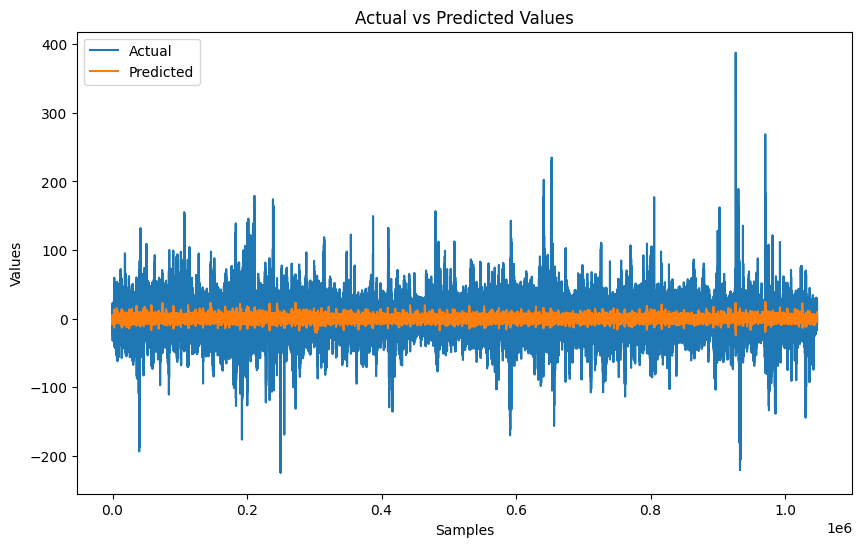

In [116]:
plot_predictions(y_test, predictions)

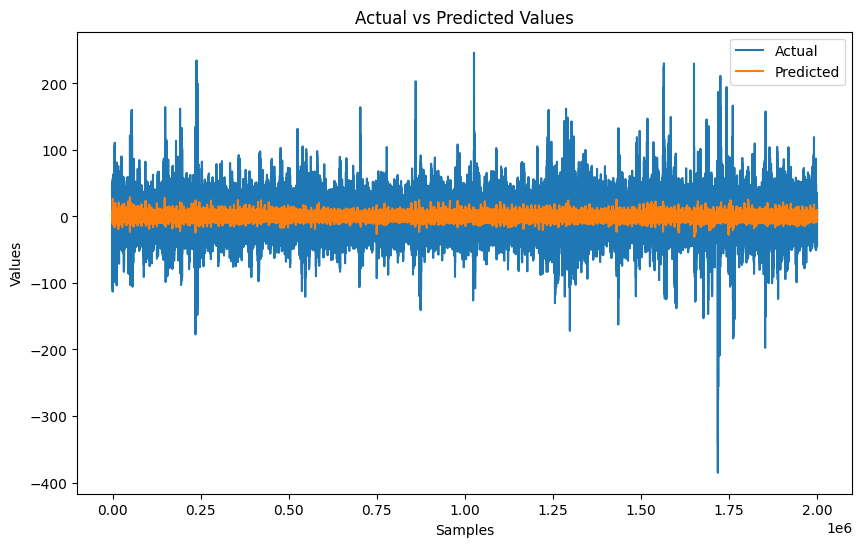

In [117]:
plot_predictions(y_train, predictions2)

In [118]:
print(predictions.min(), predictions.max())

-24.06064199304537 24.510386030796994


In [ ]:
# convert to numpy arrays
# X_train = X_train.values
# X_test = X_test.values

In [ ]:
model = lgbm

In [ ]:
# # Uncomment to use NN as the model instead
# # convert to numpy arrays
# X_train = X_train.values
# X_test = X_test.values
# # creating the model and fitting it on the data from the original sklearn train test split
# model = PyTorchMLP(input_size=X_train.shape[1], hidden_size=128)
# model.fit(X_train, y_train, X_test, y_test, epochs=2, batch_size=256, learning_rate=0.001, device=device)

# Generating Predictions

Only for Kaggle:
When uploading notebook, make sure to add the Optiver data on the right side of the screen.

In [ ]:
if kaggle_environment:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()

In [ ]:
# Uncomment this cell to try to get unstuck from having to restart and run the whole notebook again
# submit_dummy_predictions(env, sample_prediction)

In [ ]:
if kaggle_environment:
    # To count how many time the "for loop" runs.
    counter = 0

    # init 3 empty lists
    test_ls, revealed_targets_ls, sample_prediction_ls = [], [], []
    cumulative_test_df = pd.DataFrame()

    for (test_in, revealed_targets, sample_prediction) in iter_test:
        # Append the dataframe that API return into the list.
        test_ls.append(test_in.copy())
        revealed_targets_ls.append(revealed_targets.copy())
        sample_prediction_ls.append(sample_prediction.copy())

        recent_rows = cumulative_test_df.tail(2000)
        cumulative_test_df = pd.concat([recent_rows, test_in], axis=0, ignore_index=True)

        # Generate features
        test_transformed = generate_features(cumulative_test_df, test_in, pipeline)

        # Writes our predictions 
        sample_prediction["target"] = model.predict(test_transformed)
        
        # This line submit our predictions.
        env.predict(sample_prediction)
        counter += 1

    print('\n', '=' * 50, sep="")
    print(f"counter: {counter}")

In [ ]:
# cumulative_test_df.to_csv('file.csv')

In [ ]:
y_test.var()